<a href="https://colab.research.google.com/github/Jmountford3/Portfolio-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install visualkeras
!pip install noisereduce

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 10.0 MB/s eta 0:00:00


In [ ]:
import os
import warnings
import matplotlib.pyplot as plt #used for plotting mathematical graphs
import tensorflow as tf
import librosa # import audio processing library
import librosa.display # used for displaying the audio in graphs and charts
import noisereduce as nr
import numpy as np
import tqdm
import cv2
import visualkeras
from scipy.io import wavfile
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay # used to display metrics of the models performance
from sklearn.utils import class_weight
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# change the current working directory
os.chdir('/content/drive/MyDrive/Project/data')
warnings.filterwarnings('ignore')

Mounted at /content/drive


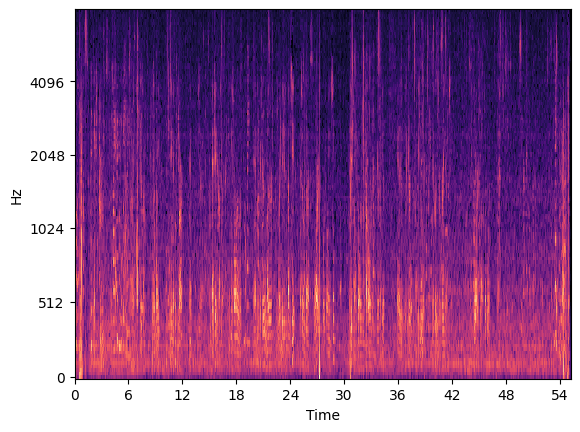

In [ ]:
audio_file = "mp3/Alzheimers/001-0.mp3"

y, sr = librosa.load(audio_file, sr=None) # y represnts the audio dimesnions, sr is the sample rate

mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000, n_fft=2048, hop_length=512) #
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)# displays the Mel Spectrogram

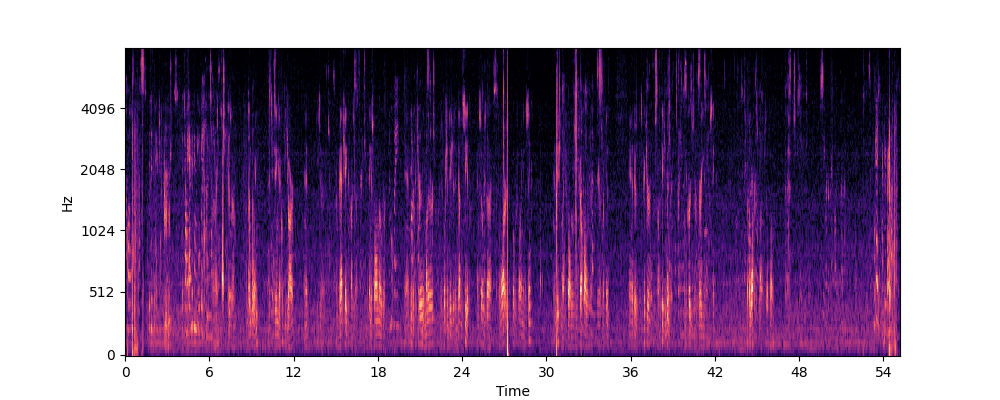

In [ ]:
Image(filename='mel/Alzheimers/001-0.png') #Same Mel but with noise reduction applied

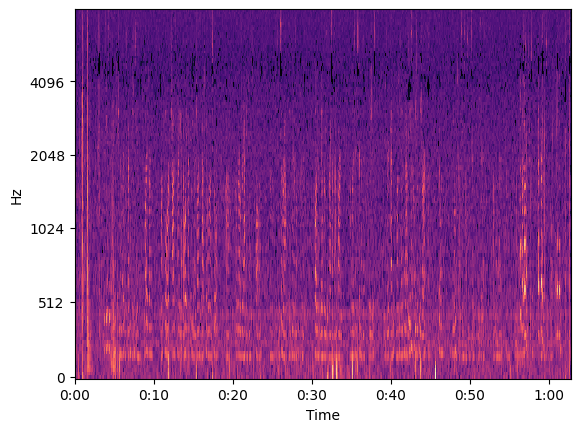

In [ ]:
audio_file = "mp3/Control/002-0.mp3"

y, sr = librosa.load(audio_file, sr=None) # y represnts the audio dimesnions, sr is the sample rate

mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000, n_fft=2048, hop_length=512) #
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)# displays the Mel Spectrogram

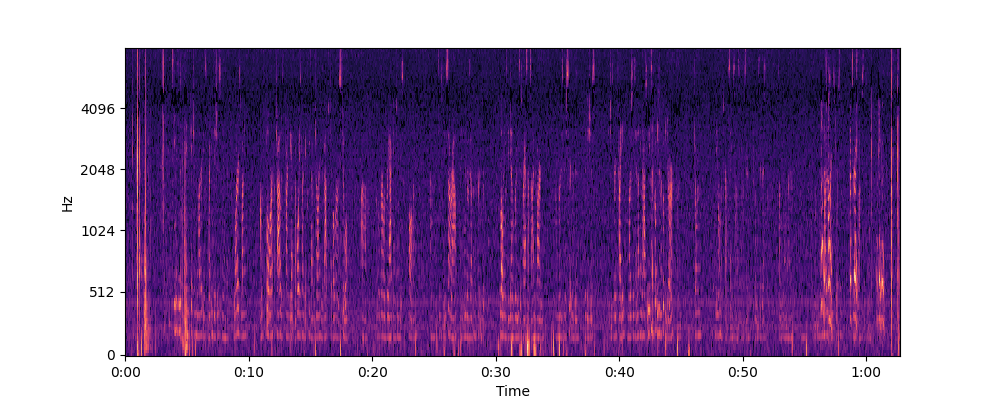

In [ ]:
Image(filename='mel/Control/002-0.png') # shows same mel but with noise reduce applied

In [ ]:
sound_folder = 'mp3/Alzheimers'
mel_folder = 'mel/Alzheimers'

def save_mel_spectrogram(mp3_file):
    y, sr = librosa.load(mp3_file, sr=None)

    if len(y) > sr:
      y = nr.reduce_noise(y=y, sr=sr, stationary=True, prop_decrease=0.8) #if the audio is longer than the sample rate, reduce background noise by a figure of 0.8, quite heavy noise reduction


    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000, n_fft=2048, hop_length=512) # assign the dimensions of each Mel Spec
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max) # plot the mel to db
    spec_img_path = os.path.join(mel_folder, os.path.splitext(os.path.basename(mp3_file))[0] + '.png') #save the image

    if os.path.exists(spec_img_path):
      return

    # Plot the Mel Spectrogram before saving
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.savefig(spec_img_path)
    plt.close()

In [ ]:
for mp3_file in tqdm.tqdm(os.listdir(sound_folder), desc = "Processing MP3 files"):
    mp3_path = os.path.join(sound_folder, mp3_file)

    if mp3_path.endswith('.mp3'): # if the file is an mp3 run the save_mel function
        save_mel_spectrogram(mp3_path)

Processing MP3 files: 100%|██████████| 334/334 [28:00<00:00,  5.03s/it]


In [ ]:
sound_folder = 'mp3/Control'
mel_folder = 'mel/Control'

for mp3_file in tqdm.tqdm(os.listdir(sound_folder), desc = "Processing MP3 files"):
    mp3_path = os.path.join(sound_folder, mp3_file)

    if mp3_path.endswith('.mp3'):
        save_mel_spectrogram(mp3_path)

Processing MP3 files: 100%|██████████| 269/269 [19:32<00:00,  4.36s/it]


In [ ]:
label_mapping = {
    'Alzheimers': 1, # assigns Alzhimers to label 1 meaning positive
    'Control': 0 # assigns Control to label 0 meaning negative
}

directories = ['Control', 'Alzheimers']

labels = [] # creates an array for the different classifications to be placed into
mels = [] # creates an array for the Mel Spectograms to be placed into

for d in directories:
  label_dir = os.path.join("mel", d)
  file_names = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".png")]

  for f in file_names:
    labels.append(label_mapping[d]) # giving each mel a label
    img = cv2.imread(f)
    imresize = cv2.resize(img, (250, 200))
    mels.append(imresize)

In [ ]:
mels = np.array(mels)
mels.shape # the number of mels and the size of each one

(603, 200, 250, 3)

In [ ]:
labels = np.array(labels)
labels.shape #checks there are the correct number of lables within the dataset

(603,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(mels, labels, test_size=0.2, random_state=1234) # create test to split ratio of 80/20

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights)) # balance the class weights to account for less control samples

In [ ]:
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0 # normalising the data

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape) #checks the new train and split datasets valuwa

(482, 200, 250, 3)
(482,)
(121, 200, 250, 3)
(121,)


In [ ]:
print("Min value:", X_train[0].min(), "Max value:", X_train[0].max()) # checking the min/max values are correct

Min value: 0.0 Max value: 1.0


In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=10) #used to stop the model early if it there is stagnation in the training accuracy to rpevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6) # used to reduce the learning rate of the model to prevent overfitting and increase val accuracy
model_chk = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True) # used to save the best version of the model

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train) #balancing all the class weights to not skew the results
class_weights = dict(enumerate(class_weights)) #creates a dictrionary to store the weights


datagen = ImageDataGenerator(
    rotation_range=10, #degree to what the image is rotated
    width_shift_range=0.15, #degree to what the image is stretched
    height_shift_range=0.15,
    shear_range=0.15, # the degree to which the image will be dragged
    zoom_range=0.15,
    horizontal_flip=True, # if the image will be flipped horizontally
    fill_mode='nearest'
)

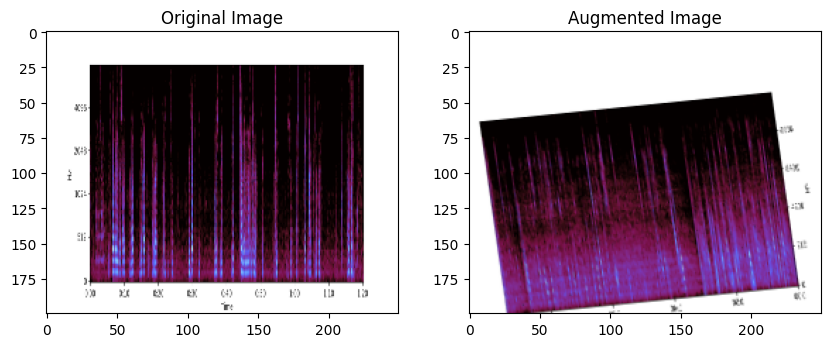

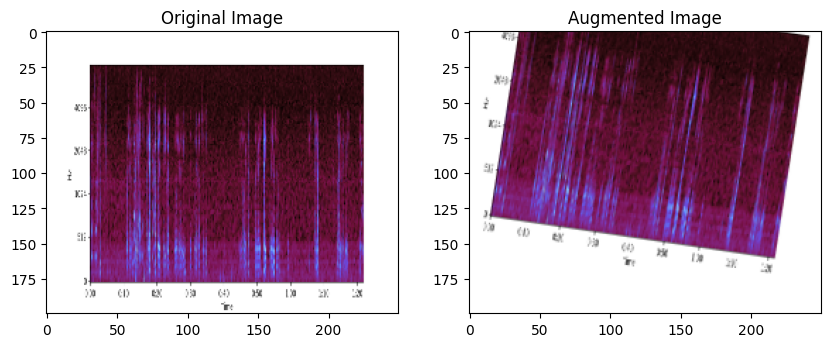

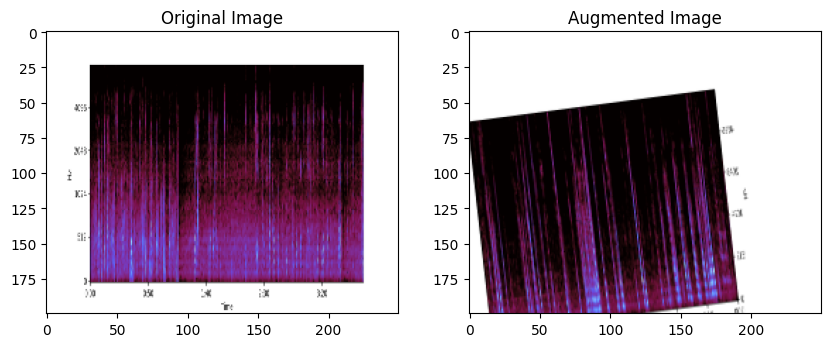

In [ ]:
augmented_images = datagen.flow(X_train[:3], batch_size=3)  # Augment 5 images

# Display original and augmented images
for i in range(3):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[0][i], cmap='grey')
    plt.title('Augmented Image')
    plt.show()

In [ ]:
input_layer = Input(shape=(200, 250, 3)) # the size of the images being inputted to the network

x1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
x2 = MaxPooling2D(pool_size=(2,2))(x1)
x3 = BatchNormalization()(x2)
x4 = Dropout(0.2)(x3)
x5 = Conv2D(32, (3, 3), activation='relu')(x4)
x6 = MaxPooling2D(pool_size=(5, 5))(x5)
x7 = Dropout(0.2)(x6)

f = Flatten()(x7)

d1 = Dense(64, activation='relu')(f)
output_layer = Dense(1, activation='sigmoid')(d1)

model = Model(inputs=input_layer, outputs=output_layer)

epochs = 125 # number of times the data will be ran through the CNN
model.compile(loss='binary_crossentropy', # binary crossentropy as there are only two possible outcomes
              optimizer=AdamW(learning_rate=0.001),
              metrics=['accuracy', #display the accuracy score
                       tf.keras.metrics.Precision(name='precision'), # display the precision score
                       tf.keras.metrics.Recall(name='recall')]), # display the recall score
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 248, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 124, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 99, 124, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 122, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14592)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       933,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 944,161 (3.60 MB)

 Trainable params: 944,161 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

None


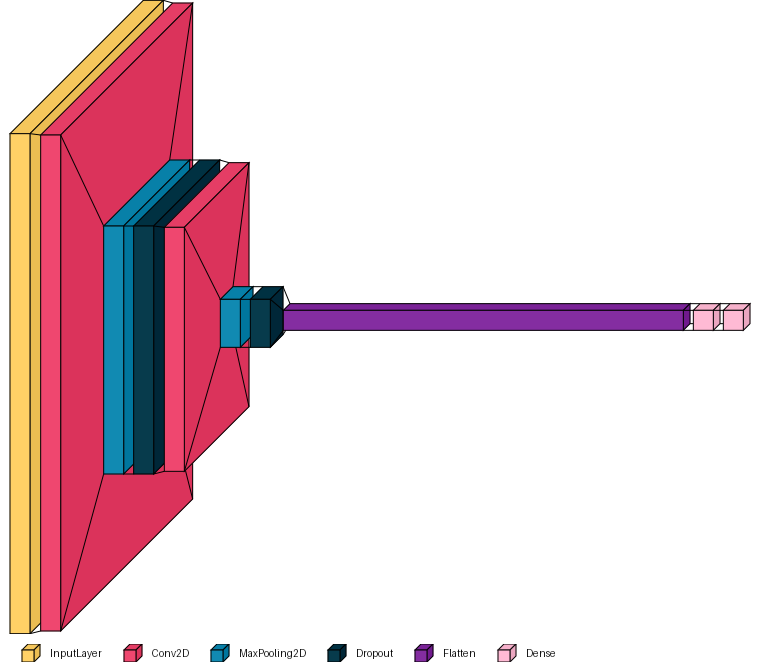

In [ ]:
visualkeras.layered_view(model, legend=True, scale_xy = 2) # displays a visualisation of the CNN model

In [ ]:
seed = 1234
np.random.seed(seed)
batch_size = 64 # splits the data set into 64 seperate batches to execute through and learn from
history = model.fit(datagen.flow(X_train, y_train), validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[callback, reduce_lr, model_chk], class_weight=class_weights)

print(len(history.history['loss']))

Epoch 1/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.5079 - loss: 0.6930 - precision: 0.5568 - recall: 0.5616 - val_accuracy: 0.5455 - val_loss: 0.6924 - val_precision: 0.6364 - val_recall: 0.3281 - learning_rate: 2.7000e-05
Epoch 2/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5601 - loss: 0.6961 - precision: 0.5814 - recall: 0.5610 - val_accuracy: 0.5372 - val_loss: 0.6924 - val_precision: 0.6429 - val_recall: 0.2812 - learning_rate: 2.7000e-05
Epoch 3/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4976 - loss: 0.6982 - precision: 0.5268 - recall: 0.5461 - val_accuracy: 0.5372 - val_loss: 0.6924 - val_precision: 0.6429 - val_recall: 0.2812 - learning_rate: 2.7000e-05
Epoch 4/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.4712 - loss: 0.6981 - precision: 0.5070 - recall: 0.4657 - val_accuracy: 0.5455 - val_loss: 0.6924 - val_precision: 0.6364 - val_recall: 0.3281 - learning_rate: 2.7000e-05
Epoch 5/125
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step -

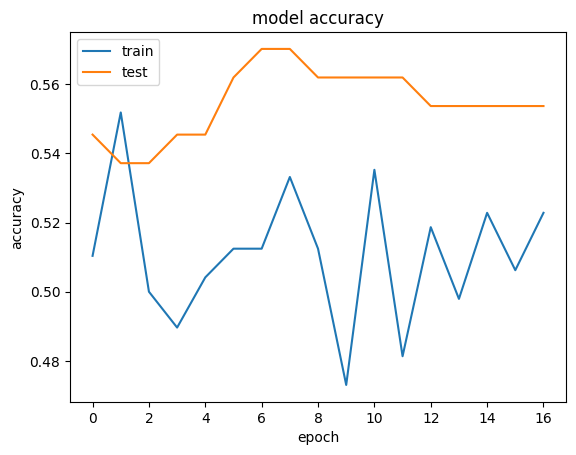

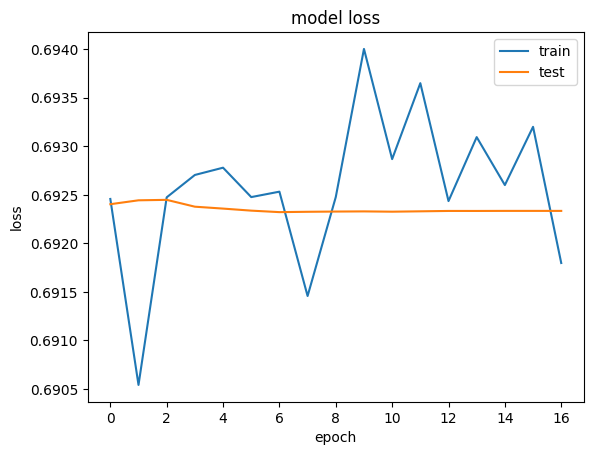

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
preds = model.predict(X_test)
preds = (preds > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)
y_true = y_test
print(classification_report(y_true, preds.flatten(), target_names=directories))  # Flatten preds to match y_true shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step
              precision    recall  f1-score   support

     Control       0.52      0.77      0.62        57
  Alzheimers       0.64      0.36      0.46        64

    accuracy                           0.55       121
   macro avg       0.58      0.57      0.54       121
weighted avg       0.58      0.55      0.54       121



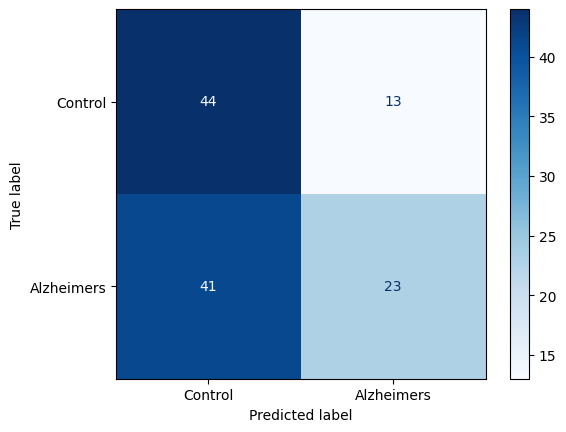

In [ ]:
cm = confusion_matrix(y_true, preds.flatten())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=directories)
disp.plot(cmap=plt.cm.Blues)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 722ms/step


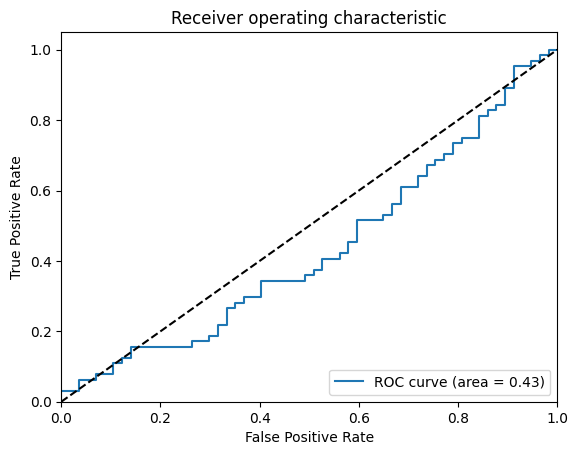

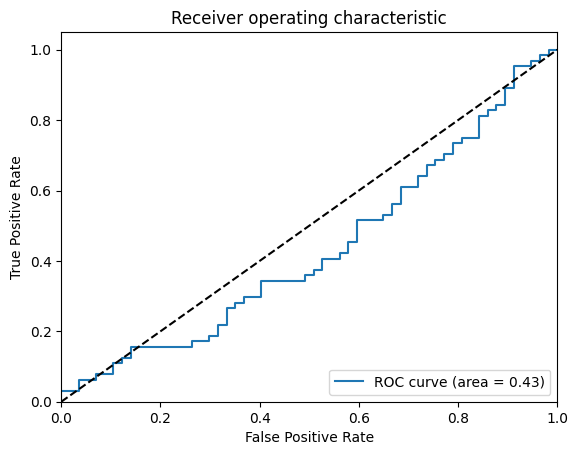

In [ ]:
y_score = model.predict(X_test) # get the prediction probabilities

num_classes = 2
# Compute ROC curve and ROC area for each class

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):

    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, 0])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot of a ROC curve for a specific class
for i in range(num_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
accuracy_scores = []
losses_scores = []
precision_scores = []
recall_scores = []

for fold, (train_index, val_index) in enumerate(skf.split(mels, labels)):
    print(f"Fold {fold+1}/{n_splits}")

    X_train_fold, X_val_fold = mels[train_index], mels[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    X_train_fold = X_train_fold.astype('float32') / 255.0
    X_val_fold = X_val_fold.astype('float32') / 255.0


    class_weights_fold = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train_fold), y=y_train_fold)
    class_weights_fold = dict(enumerate(class_weights_fold))


    input_layer = Input(shape=(200, 250, 3))
    x1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
    x2 = MaxPooling2D(pool_size=(2,2))(x1)
    x3 = Dropout(0.2)(x2)
    x4 = Conv2D(32, (3, 3), activation='relu')(x3)
    x5 = MaxPooling2D(pool_size=(5, 5))(x4)
    x6 = Dropout(0.2)(x5)
    f = Flatten()(x6)
    d1 = Dense(64, activation='relu')(f)
    output_layer = Dense(1, activation='sigmoid')(d1)
    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy',
                  optimizer=AdamW(learning_rate=0.001),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])


    datagen_fold = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    epochs = 125


    history = model.fit(datagen_fold.flow(X_train_fold, y_train_fold),validation_data=(X_val_fold, y_val_fold),epochs=epochs,verbose=0,callbacks=[callback, reduce_lr],class_weight=class_weights_fold)


    loss, accuracy, precision, recall = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    losses_scores.append(loss)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)



print("\nAverage Metrics:")
print(f"Average Loss: {np.mean(losses_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Average Precision: {np.mean(precision_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Average Metrics:
Average Loss: 0.6934
Average Accuracy: 0.5009
Average Precision: 0.4740
Average Recall: 0.4000
